### Planteamiento del sistema, discretizando el laplaciano.

Inicialmente tenemos que el laplaciano es:
$$
\nabla^2 u(x,y) = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}
$$


### Vamos a encontrar estas **segunda derivadas** a través de la **serie de Taylor** alrededor del punto \( x \):

$$
f(x+h) = f(x) + h f'(x) + \frac{h^2 f''(x)}{2} + \frac{h^3 f^{(3)}(x)}{6} + O(h^4)
$$

$$
f(x-h) = f(x) - h f'(x) + \frac{h^2 f''(x)}{2} - \frac{h^3 f^{(3)}(x)}{6} + O(h^4)
$$

Sumando las dos ecuaciones tenemos que:

$$
f(x+h) + f(x-h) = 2f(x) + h^2 f''(x) + O(h^4)
$$

Luego,

$$
\frac{f(x+h) - 2f(x) + f(x-h)}{h^2} + O(h^2) = f''(x)
$$

Así que podemos aproximar \( f''(x) \) como:

$$
f^{(2)}(x) \approx \frac{f(x+h) - 2f(x) + f(x-h)}{h^2}
$$

De esta manera podemos aproximar el operador laplaciano 2D de tal manera que:

$$
\nabla^2 u(x,y) = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \approx \frac{u(x+h,y) - 2u(x,y) + u(x-h,y)}{h^2} + \frac{u(x,y+h) - 2u(x,y) + u(x,y-h)}{h^2}
$$

Luego,

$$
\nabla^2 u(x,y) \approx \frac{u(x+h,y) + u(x-h,y) + u(x,y+h) + u(x,y-h) - 4u(x,y)}{h^2}
$$


#### Discretización del problema

Dado que queremos pasos discretos, tomaremos el paso $h$ como $h=1$.

Cuando discretizamos el operador Laplaciano ($ \nabla^2 u\ $), la ecuación de diferencias finitas centrales queda como:
$$

u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j} = f_{i,j}

$$

### Matriz dispersa del Laplaciano 2D mediante producto de Kronecker

En una dimensión, la discretización clásica del operador Laplaciano (usando paso de malla $$h=1$$ para simplificar) se representa con la matriz tridiagonal:

$$
D =
\begin{pmatrix}
-2 & 1  & 0  & \cdots & 0 \\
1 & -2 & 1  & \cdots & 0 \\
0 & 1 & -2 & \cdots & 0 \\
\vdots &   &   & \ddots & 1 \\
0 & 0 & 0 & 1 & -2
\end{pmatrix}_{n \times n},
$$

la cual actúa sobre un vector de $$n$$ incógnitas 

$$
\bigl(u_1,\,u_2,\dots,u_n\bigr).
$$

Para el caso 2D en una malla regular de tamaño $$n \times n$$ (con $$n^2$$ incógnitas totales), ordenamos las variables en un vector columna:

$$
U 
= 
\bigl(
u_{1,1},\,u_{1,2},\dots,u_{1,n},\,u_{2,1},\dots,u_{n,n}
\bigr)^\top.
$$

El Laplaciano discreto en 2D, con _stencil_

$$
(\nabla^2 u)_{i,j} 
= 
u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4\,u_{i,j},
$$

puede representarse por una gran matriz dispersa de tamaño $$n^2 \times n^2$$.  
Observando su estructura de adyacencia (cada nodo se conecta con sus cuatro vecinos y consigo mismo), se ve que esta matriz puede construirse mediante el **producto de Kronecker**. 

Si definimos:

$$
I_n 
= 
\begin{pmatrix}
1 & 0 & \cdots & 0 \\
0 & 1 & \cdots & 0 \\
\vdots & \vdots & \ddots & 0 \\
0 & 0 & \cdots & 1
\end{pmatrix}_{n\times n},
$$

entonces la matriz que discretiza el Laplaciano 2D se puede expresar como:

$$
A
=
(I_n \otimes D)
+
(D \otimes I_n),
$$


donde $\otimes$ denota el producto de Kronecker. En esta construcción:

- $I_n \otimes D$ actúa en la dirección de las filas,
- $D \otimes I_n$ introduce la dependencia en la dirección de las columnas.

Así, cada fila (o columna) de la matriz global refleja el _stencil_ del operador Laplaciano en 2D:

$$
(\nabla^2 u)_{i,j}
=
u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4\,u_{i,j}.
$$


In [11]:
from scipy.sparse import diags, kron, identity
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import NDArray

IntArray = NDArray[np.int16]

In [ ]:
data = scipy.io.loadmat('bordes1.mat')
u: IntArray = data["bordes1"]

### Generamos la matriz dispersa 

In [ ]:
from scipy.sparse import diags, kron, identity

N, M = u.shape
Dx = diags([-1, 2, -1], [-1, 0, 1], shape=(N, N))
Dy = diags([-1, 2, -1], [-1, 0, 1], shape=(M, M))

A = kron(identity(M), Dx) + kron(Dy, identity(N))


### Resolvamos el sistema

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve

f_vector = u.flatten()
N, M = u.shape  # Tamaño de la imagen

# 📌 Asegurar que f_vector tenga la dimensión correcta
assert f_vector.shape == (A.shape[0],), "Dimensión incorrecta de f_vector"

# 📌 1. Solución Exacta (Directa)
u_exacta_vector = spsolve(A, f_vector)
u_exacta = u_exacta_vector.reshape((N, M))


In [5]:

# 📌 2. Método de Jacobi
def jacobi(A, b, x0=None, tol=1e-6, max_iter=1):
    D = A.diagonal()
    R = A - np.diagflat(D)
    x = np.zeros_like(b) if x0 is None else x0.copy()

    for _ in range(max_iter):
        x_new = (b - R.dot(x)) / D
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new

    return x

u_jacobi_vector = jacobi(A, f_vector)
u_jacobi = u_jacobi_vector.reshape((N, M))


In [6]:

# 📌 3. Método de Gauss-Seidel
def gauss_seidel(A, b, x0=None, tol=1e-6, max_iter=1):
    x = np.zeros_like(b) if x0 is None else x0.copy()

    for _ in range(max_iter):
        x_old = x.copy()
        for i in range(len(b)):
            x[i] = (b[i] - A[i, :i].dot(x[:i]) - A[i, i+1:].dot(x[i+1:])) / A[i, i]
        if np.linalg.norm(x - x_old) < tol:
            break

    return x

u_gauss_seidel_vector = gauss_seidel(A, f_vector)
u_gauss_seidel = u_gauss_seidel_vector.reshape((N, M))


/tmp/ipykernel_1151789/2429811933.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = (b[i] - A[i, :i].dot(x[:i]) - A[i, i+1:].dot(x[i+1:])) / A[i, i]


In [7]:

# 📌 4. Método SOR
def sor(A, b, omega=1.5, tol=1e-6, max_iter=1):
    x = np.zeros_like(b)

    for _ in range(max_iter):
        x_old = x.copy()
        for i in range(len(b)):
            sigma = A[i, :i].dot(x[:i]) + A[i, i+1:].dot(x[i+1:])
            x[i] = (1 - omega) * x[i] + (omega / A[i, i]) * (b[i] - sigma)
        if np.linalg.norm(x - x_old) < tol:
            break

    return x

u_sor_vector = sor(A, f_vector)
u_sor = u_sor_vector.reshape((N, M))


/tmp/ipykernel_1151789/1722295509.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = (1 - omega) * x[i] + (omega / A[i, i]) * (b[i] - sigma)


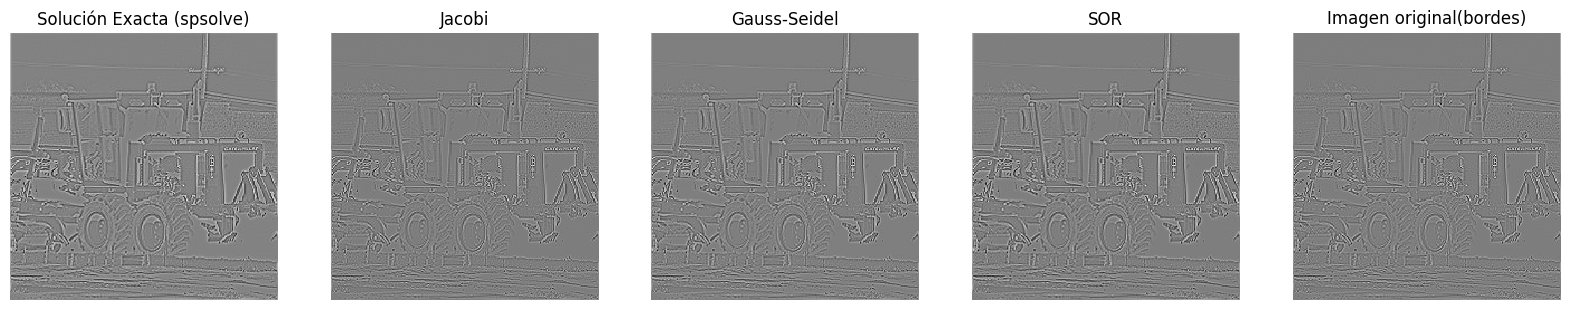

In [8]:

# 📌 Comparar soluciones
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

imagenes = [u_exacta, u_jacobi, u_gauss_seidel, u_sor, u]
titulos = ["Solución Exacta (spsolve)", "Jacobi", "Gauss-Seidel", "SOR", "Imagen original(bordes)"]

for ax, img, title in zip(axes, imagenes, titulos):
    ax.imshow(img, cmap='gray', interpolation='nearest')
    ax.set_title(title)
    ax.axis("off")

plt.show()
